In [26]:
from utils import *

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

In [27]:
# Bunny point cloud
path_to_bunny = "D:\\Skole\\Semester 10\\Prosjektoppgave\\Data\\bunny\\reconstruction\\bun_zipper.ply"
# path_to_bunny = "D:\\Runar\\Documents\\1_Studier\\Semester_10\\Prosjektoppgave\\22v-TPK4560-Prosjektoppgave-Pose_estimation\\Data\\bunny\\data\\bunny000.ply"
bunny_ply = o3d.io.read_point_cloud(path_to_bunny)
bunny = np.asarray(bunny_ply.points)
bunny_true = np.copy(bunny)
n = bunny.shape[0]

In [28]:
# Correct rotation
rot = np.array([np.pi/3,
              np.pi/3,
              np.pi/3
            ])
# Noise and outliers
noise_1 = np.array([np.pi/3 + np.random.normal(0,0.05),
                    np.pi/3 + np.random.normal(0,0.05),
                    np.pi/3 + np.random.normal(0,0.05)
                    ])
noise_2 = np.array([np.pi/3 + np.random.normal(0,0.5),
                    np.pi/3 + np.random.normal(0,0.5),
                    np.pi/3 + np.random.normal(0,0.5)
                    ])
outlier = np.array([np.pi*np.random.rand(),
                    np.pi*np.random.rand(),
                    np.pi*np.random.rand()
                    ])

In [29]:

# Generating translated cloud with inaccuracies
for i, p in enumerate(bunny):
    if i % 4 == 0:
        bunny[i] = p @ expso3(rot)
        continue
    if i % 4 == 1:
        bunny[i] = p @ expso3(noise_1)
        noise_1 = np.array([np.pi/3 + np.random.normal(0,0.005),
                    np.pi/3 + np.random.normal(0,0.005),
                    np.pi/3 + np.random.normal(0,0.005)
                    ])
        continue
    if i % 4 == 2:
        bunny[i] = p @ expso3(noise_2)
        noise_2 = np.array([np.pi/3 + np.random.normal(0,0.05),
                    np.pi/3 + np.random.normal(0,0.05),
                    np.pi/3 + np.random.normal(0,0.05)
                    ])
        continue
    if i % 4 == 3:
        bunny[i] = p @ expso3(noise_2)
        outlier = np.array([np.pi*np.random.rand(),
                    np.pi*np.random.rand(),
                    np.pi*np.random.rand()
                    ])
        continue

In [30]:
# GNC Initialization
# Initial rotation guess
R0 = np.identity(3)

# Initial loss function data
r = np.zeros(n)
for i in range(n):
    r[i] = np.linalg.norm(bunny_true[i] - R0@bunny[i])
r0_max = np.max(r)

# gnc
eps = 0.011 
mu_update_factor = 1.4
max_iterations = 1000
w = np.ones(n)
mu = eps**2 / (2*r0_max**2 - eps**2)

In [31]:
last_iter = []
R_iter = [np.sum(r)]
iterations = 0
for i in range(max_iterations):
    iterations += 1
    last_iter.append(np.sum(w))
    # Weighted Procrustes
    H = bunny.T @ np.diag(w) @ bunny_true
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ np.diag([1,1,np.linalg.det( Vt.T @ U.T)]) @ U.T

    # Loss function
    for j in range(n):
        r[j] = np.linalg.norm(bunny_true[j] - R0@bunny[j])
        w[j] = w_from_r(r[j], eps, mu)

    R_iter.append(np.sum(r))

    mu = mu_update_factor * mu

    if i >= 5:
        if np.sum(w) == last_iter[i]:
            break

In [32]:
print(R)
print(expso3(rot))

[[ 1.00  0.00  0.00]
 [ 0.00  1.00  0.00]
 [ 0.00  0.00  1.00]]
[[ 0.17 -0.15  0.97]
 [ 0.97  0.17 -0.15]
 [-0.15  0.97  0.17]]


In [33]:
inliers = []
outliers = []

for i, n in enumerate(w):
    if w[i] == 1.0:
        inliers.append(n)
    else:
        outliers.append(n)

percentage = (1-len(inliers)/(len(outliers)+len(inliers)))*100

print("Inliers:\t", len(inliers), "\nOutliers:\t", len(outliers),\
    "\nPercentage:\t",percentage, "%")

Inliers:	 0 
Outliers:	 35947 
Percentage:	 100.0 %


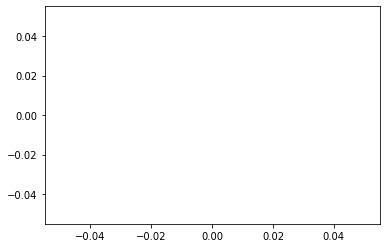

In [36]:
plt.plot(inliers)

In [34]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bunny)
o3d.visualization.draw_geometries([pcd])

In [35]:
print(last_iter)

[35947.0, 66.59542180452891, 74.48815517329858, 82.10642617102815, 88.780287134025, 94.19257726390859, 98.60645147176768, 101.02734879871011, 101.25949554263596, 99.47801198212548, 96.59383166043705, 92.64505291942803, 87.42744898042689, 81.84750476957895, 76.18033959550274, 70.18941542568618, 63.32910174365008, 55.87705687131289, 47.92921938695034, 39.65679934082695, 31.084729776777003, 22.560765182301672, 14.410637631215776, 8.336301977621059, 4.673886816729304, 3.1722203557205297, 2.103796947227745, 1.4942902615344011, 1.314666133458256, 1.174017760836212, 1.085043252454696, 0.9513921862124608, 0.7575094899634855, 0.5488523997089736, 0.4006279793450531, 0.3636760569364341, 0.31129939383696126, 0.23750816886375503, 0.13386707593906522, 0.0]
